# Техническая часть

In [1]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [2]:
!pip install -q sentence-transformers
!pip install -q razdel
!git clone -q https://github.com/DanilDmitriev1999/extractive_summarization

     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 1.3MB 7.8MB/s 
     |████████████████████████████████| 2.9MB 47.0MB/s 
     |████████████████████████████████| 890kB 41.2MB/s 
     |████████████████████████████████| 1.1MB 25.2MB/s 


In [3]:
import timeit
from itertools import combinations
import seaborn
import matplotlib.pyplot as plt
import networkx as nx
import json
import random
from tqdm import tqdm

from sentence_transformers import SentenceTransformer, util

from scipy.sparse.csgraph import connected_components

import numpy as np
from scipy.linalg import norm

from nltk.translate.bleu_score import corpus_bleu
import nltk
import razdel

from pprint import pprint

from extractive_summarization.utils import *
from extractive_summarization.text_rank import *
from extractive_summarization.lex_rank import *

# Данные

In [4]:
train_records = read_gazeta_records("gazeta_train.txt", 52400)

100%|██████████| 52400/52400 [00:04<00:00, 12906.37it/s]


# Поиск модели из Multi-Lingual Pretrained Models

Модели:

1.   `distiluse-base-multilingual-cased-v2`
2.   `xlm-r-distilroberta-base-paraphrase-v1`
3.   `distilbert-multilingual-nli-stsb-quora-ranking`



In [5]:
model = {
    'use':'distiluse-base-multilingual-cased-v2',
    'xlm-r':'xlm-r-distilroberta-base-paraphrase-v1',
    'bert':'distilbert-multilingual-nli-stsb-quora-ranking',
}

## TextRank

In [6]:
small_train_records = train_records[0:100]

In [7]:
all_blue_score = []
all_time = []
for model_name, model_full_name in model.items():
    model_n = TextRank(model_full_name)
    start_time = timeit.default_timer()
    blue_score = [model_n.get_summary(text, only_blue=True) for text in tqdm(small_train_records,
                                                                             total=len(small_train_records))]
    final_time = timeit.default_timer() - start_time
    all_blue_score.append(blue_score)
    all_time.append(final_time)


100%|██████████| 504M/504M [00:56<00:00, 8.85MB/s]
100%|██████████| 100/100 [06:28<00:00,  3.88s/it]
100%|██████████| 1.01G/1.01G [01:45<00:00, 9.62MB/s]
  8%|▊         | 8/100 [00:42<08:03,  5.25s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 100/100 [11:29<00:00,  6.90s/it]
100%|██████████| 501M/501M [00:59<00:00, 8.39MB/s]
100%|██████████| 100/100 [06:10<00:00,  3.70s/it]


In [12]:
np.median(all_blue_score, axis=1)

array([0.29048268, 0.2753402 , 0.25260427])

In [9]:
def get_len_text(text):
    text = text['text']
    sentences = len([sentence.text for sentence in razdel.sentenize(text)])
    return sentences

all_len_sentence = [get_len_text(text) for text in small_train_records]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


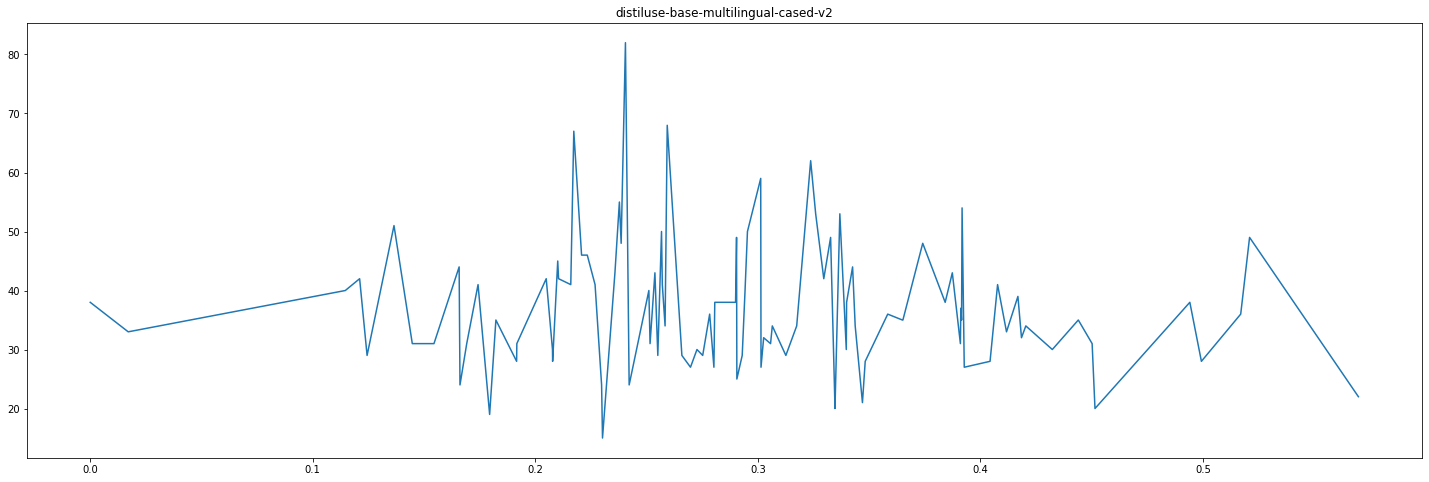

In [21]:
plt.figure(figsize=(25,8))
plt.title('distiluse-base-multilingual-cased-v2')
seaborn.lineplot(all_blue_score[0], all_len_sentence)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


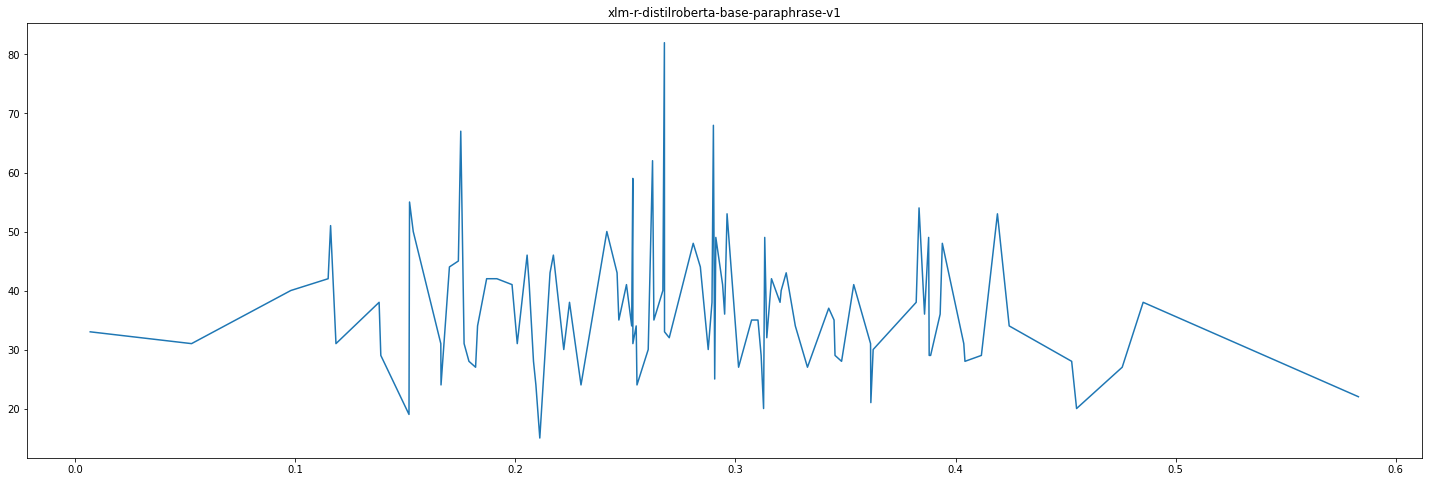

In [22]:
plt.figure(figsize=(25,8))
plt.title('xlm-r-distilroberta-base-paraphrase-v1')
seaborn.lineplot(all_blue_score[1], all_len_sentence)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


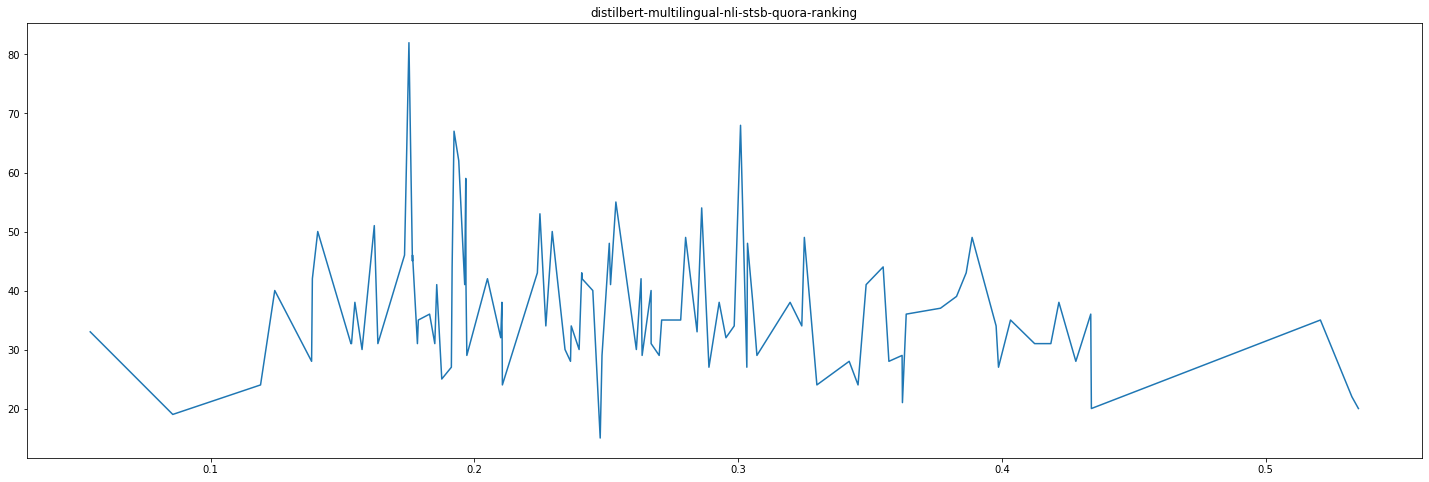

In [24]:
plt.figure(figsize=(25,8))
plt.title('distilbert-multilingual-nli-stsb-quora-ranking')
seaborn.lineplot(all_blue_score[2], all_len_sentence)

# LexRank

In [25]:
all_blue_score = []
all_time = []
for model_name, model_full_name in model.items():
    model_n = LexRank(model_full_name)
    start_time = timeit.default_timer()
    blue_score = [model_n.get_summary(text, only_blue=True) for text in tqdm(small_train_records,
                                                                             total=len(small_train_records))]
    final_time = timeit.default_timer() - start_time
    all_blue_score.append(blue_score)
    all_time.append(final_time)

100%|██████████| 100/100 [06:35<00:00,  3.95s/it]


In [26]:
np.median(all_blue_score, axis=1)

array([0.28301954, 0.27036417, 0.26082103])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


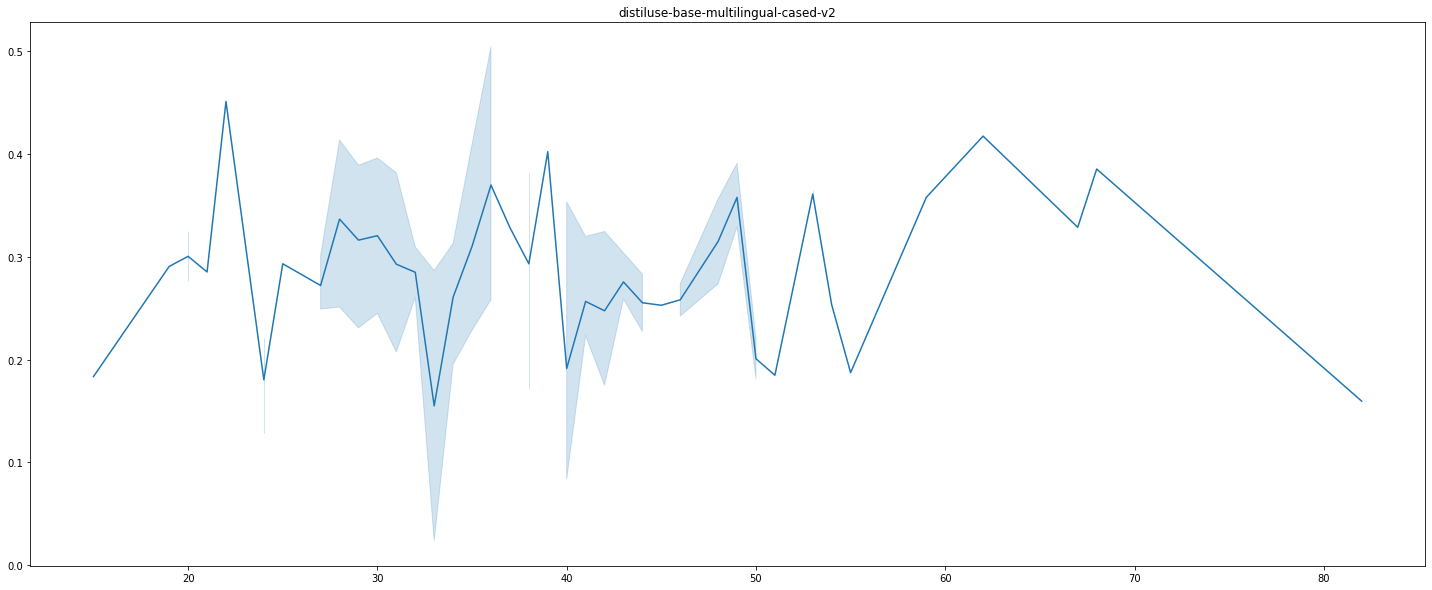

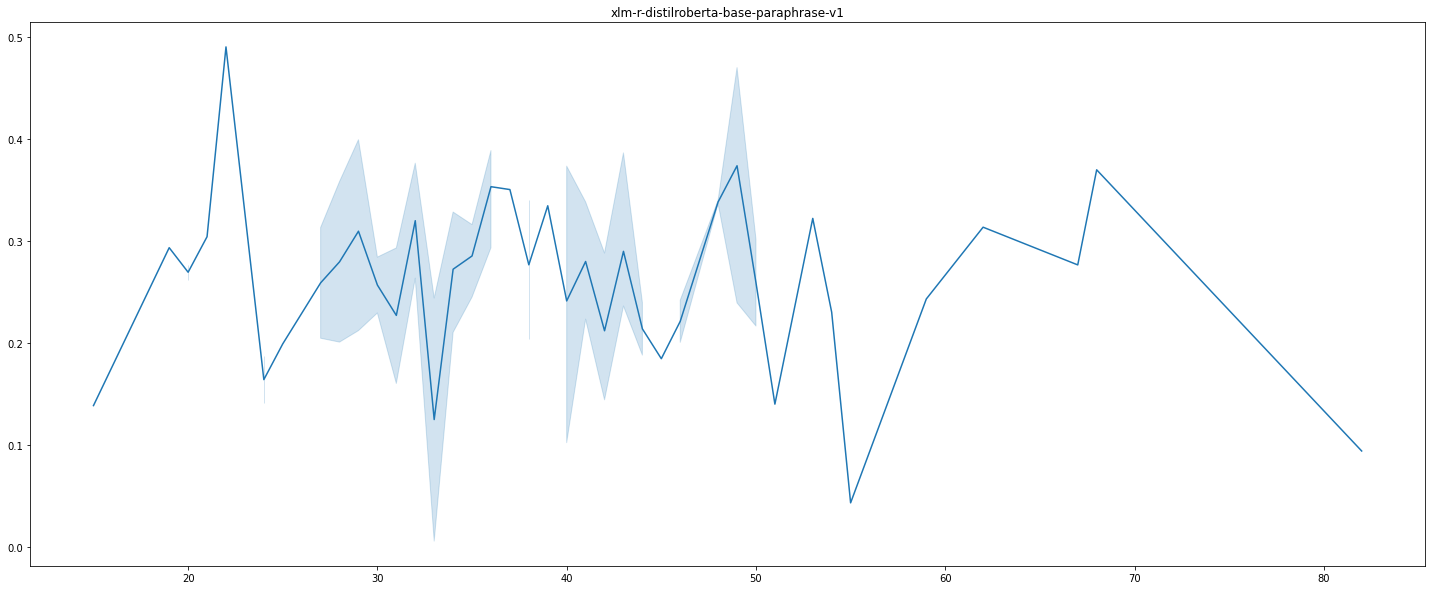

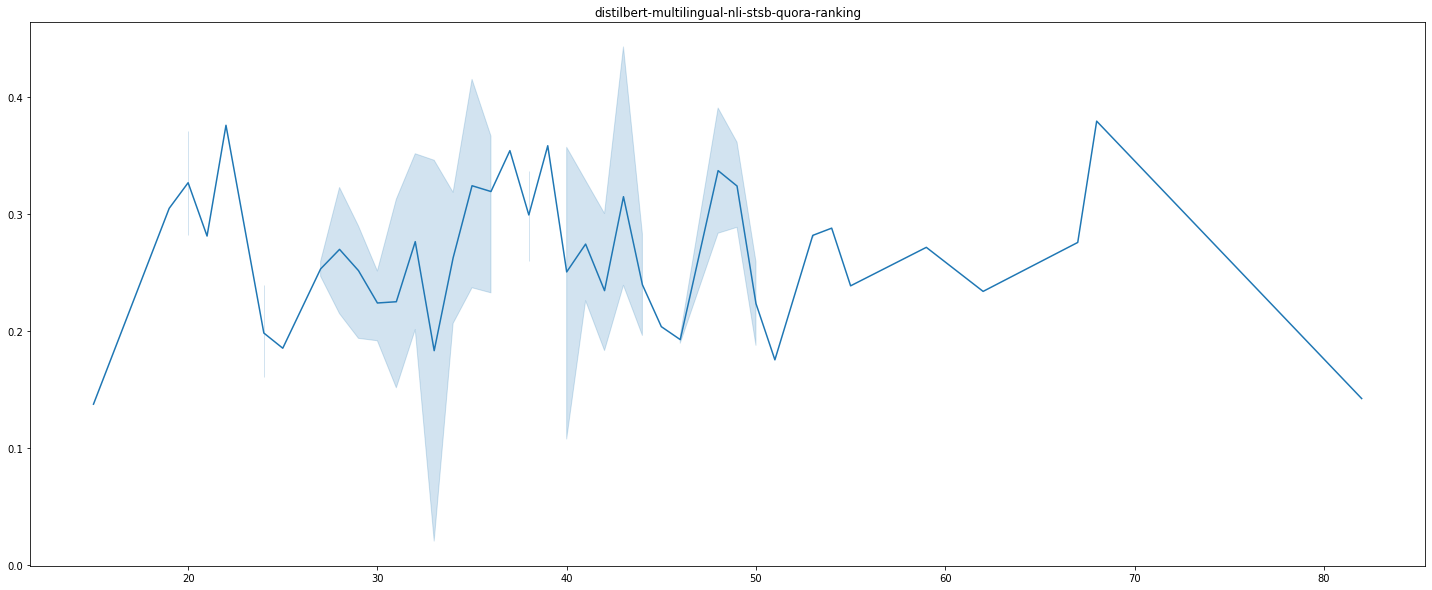

In [33]:
plt.figure(figsize=(25,10))
plt.title('distiluse-base-multilingual-cased-v2')
seaborn.lineplot(all_len_sentence, all_blue_score[0])

plt.figure(figsize=(25,10))
plt.title('xlm-r-distilroberta-base-paraphrase-v1')
seaborn.lineplot(all_len_sentence, all_blue_score[1])

plt.figure(figsize=(25,10))
plt.title('distilbert-multilingual-nli-stsb-quora-ranking')
seaborn.lineplot(all_len_sentence, all_blue_score[2])